In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_transactions = pd.read_excel('FinalDataset.xlsx')
df_addresses = pd.read_csv('Featuers_Extraction.csv')

print("=" * 70)
print("ШАГ 1: СОЗДАНИЕ ОЧИЩЕННЫХ И ОБЪЕДИНЕННЫХ ДАННЫХ")
print("=" * 70)

# 1. Создаем очищенный датасет транзакций с важными признаками газа
print("1.1. Создание очищенного датасета транзакций...")
transaction_features = [
    'from_address', 'to_address', 'value', 'gas', 'gas_price',
    'receipt_gas_used', 'block_timestamp', 'from_scam', 'to_scam'
]

df_trans_clean = df_transactions[transaction_features].copy()

# Создаем новый важный признак: эффективность использования газа
df_trans_clean['gas_used_ratio'] = df_trans_clean['receipt_gas_used'] / df_trans_clean['gas']
# Заменяем бесконечные значения (если gas=0) на 1
df_trans_clean['gas_used_ratio'] = df_trans_clean['gas_used_ratio'].replace([np.inf, -np.inf], 1.0)
df_trans_clean['gas_used_ratio'] = df_trans_clean['gas_used_ratio'].fillna(1.0)

print(f"   Добавлен новый признак: gas_used_ratio")
print(f"   Очищенные транзакции: {df_trans_clean.shape[1]} колонок")

# 2. Создаем очищенный датасет адресов (убираем избыточные признаки)
print("\n1.2. Создание очищенного датасета адресов...")
address_features = [
    'Address', 'in_degree', 'out_degree',
    'Avg amount incoming', 'Avg amount outgoing',
    'Avg time incoming', 'Avg time outgoing',
    'Active Duration', 'Clustering coefficient',
    'Avg gas price', 'Avg gas limit'
]

df_addr_clean = df_addresses[address_features].copy()
print(f"   Очищенные адреса: {df_addr_clean.shape[1]} колонок")

# 3. Объединяем транзакции с признаками отправителя и получателя
print("\n1.3. Объединение данных...")

# С отправителями
df_merged = pd.merge(
    df_trans_clean,
    df_addr_clean,
    left_on='from_address',
    right_on='Address',
    how='left',
    suffixes=('', '_sender')
)

# Добавляем префикс к признакам отправителя
sender_cols = [c for c in df_addr_clean.columns if c != 'Address']
for col in sender_cols:
    if col in df_merged.columns:
        df_merged.rename(columns={col: f'sender_{col}'}, inplace=True)

# С получателями
df_merged = pd.merge(
    df_merged,
    df_addr_clean,
    left_on='to_address',
    right_on='Address',
    how='left',
    suffixes=('', '_receiver')
)

# Добавляем префикс к признакам получателя
for col in sender_cols:
    if col in df_merged.columns:
        df_merged.rename(columns={col: f'receiver_{col}'}, inplace=True)

# Удаляем временные колонки
df_merged.drop(['Address', 'Address_receiver', 'from_address', 'to_address'], 
               axis=1, errors='ignore', inplace=True)

# 4. Создаем целевую переменную
df_merged['is_scam'] = (df_merged['from_scam'] == 1) | (df_merged['to_scam'] == 1)
df_merged['is_scam'] = df_merged['is_scam'].astype(int)
df_merged.drop(['from_scam', 'to_scam'], axis=1, inplace=True)

print(f"\n1.4. Итоговый датасет: {df_merged.shape[0]} строк, {df_merged.shape[1]} колонок")
print(f"   Целевая переменная is_scam: {df_merged['is_scam'].mean():.2%} положительных")

print("=" * 70)
print("ШАГ 2: ПРОВЕРКА КОРРЕЛЯЦИЙ В ОЧИЩЕННЫХ ДАННЫХ")
print("=" * 70)

# Анализируем только топ-15 самых коррелированных признаков
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns

if 'is_scam' in numeric_cols:
    correlations = {}
    for col in numeric_cols:
        if col != 'is_scam':
            corr = df_merged[col].corr(df_merged['is_scam'])
            if not pd.isna(corr):
                correlations[col] = abs(corr)
    
    # Топ-15 признаков по корреляции с целью
    top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:15]
    
    print("\nТоп-10 признаков по корреляции с мошенничеством:")
    for i, (feat, corr) in enumerate(top_features[:10]):
        print(f"  {i+1:2}. {feat:30} | Корреляция: {corr:+.4f}")
    
    # Визуализация для топ-15
    top_feature_names = [feat[0] for feat in top_features] + ['is_scam']
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_merged[top_feature_names].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True, linewidths=0.5)
    plt.title('Корреляции топ-15 признаков с is_scam (очищенные данные)', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("ДАННЫЕ ГОТОВЫ ДЛЯ CATBOOST")
print("=" * 70)
print("Теперь признаки:")
print("1. Очищены от избыточности (убраны дублирующиеся amount/time признаки)")
print("2. Сохраняют важные аспекты газа (gas, gas_price, gas_used_ratio)")
print("3. Имеют умеренные корреляции (без сильной мультиколлинеарности)")
print("4. Готовы для хронологического разделения и обучения CatBoost")

# Сохраняем финальный датасет
df_merged.to_csv('cleaned_unified_dataset.csv', index=False)
print(f"\nСохранено в: cleaned_unified_dataset.csv")

ШАГ 3: ХРОНОЛОГИЧЕСКОЕ РАЗДЕЛЕНИЕ ДАННЫХ
Преобразование времени...
Хронологическое разделение...
Новое распределение (случайное, стратифицированное):
Обучающая:   49,872 записей (70.0%) | Скам: 20.00%
Валидационная: 10,690 записей (15.0%) | Скам: 20.00%
Тестовая:    10,688 записей (15.0%) | Скам: 20.00%

ПЕРЕОБУЧЕНИЕ CATBOOST НА ИСПРАВЛЕННЫХ ДАННЫХ

4.1. Настройка параметров CatBoost...
Параметры модели:
  iterations: 1000
  learning_rate: 0.05
  depth: 6
  l2_leaf_reg: 3
  random_seed: 42
  verbose: 100
  early_stopping_rounds: 50
  eval_metric: F1
  loss_function: Logloss
  auto_class_weights: Balanced
  use_best_model: True

4.2. Обучение модели...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9002949	test: 0.9008676	best: 0.9008676 (0)	total: 5.74ms	remaining: 5.74s
100:	learn: 0.9923823	test: 0.9920771	best: 0.9920771 (100)	total: 434ms	remaining: 3.87s
200:	learn: 0.9972530	test: 0.9948406	best: 0.9948406 (197)	total: 870ms	remaining: 3.46s
300:	learn: 0.9985833	test: 0.9965431	best: 0.9965431 (282)	total: 1.33s	remaining: 3.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9965430685
bestIteration = 282

Shrink model to first 283 iterations.

4.3. Оценка на валидационной выборке...

Классификационный отчет (валидация):
               precision    recall  f1-score   support

   Нормальные       1.00      1.00      1.00      8552
Мошеннические       0.99      0.99      0.99      2138

     accuracy                           1.00     10690
    macro avg       1.00      1.00      1.00     10690
 weighted avg       1.00      1.00      1.00     10690

Матрица ошибок (валидация):
             Прогноз: Норма  Прогноз: Скам
Факт: Норма            

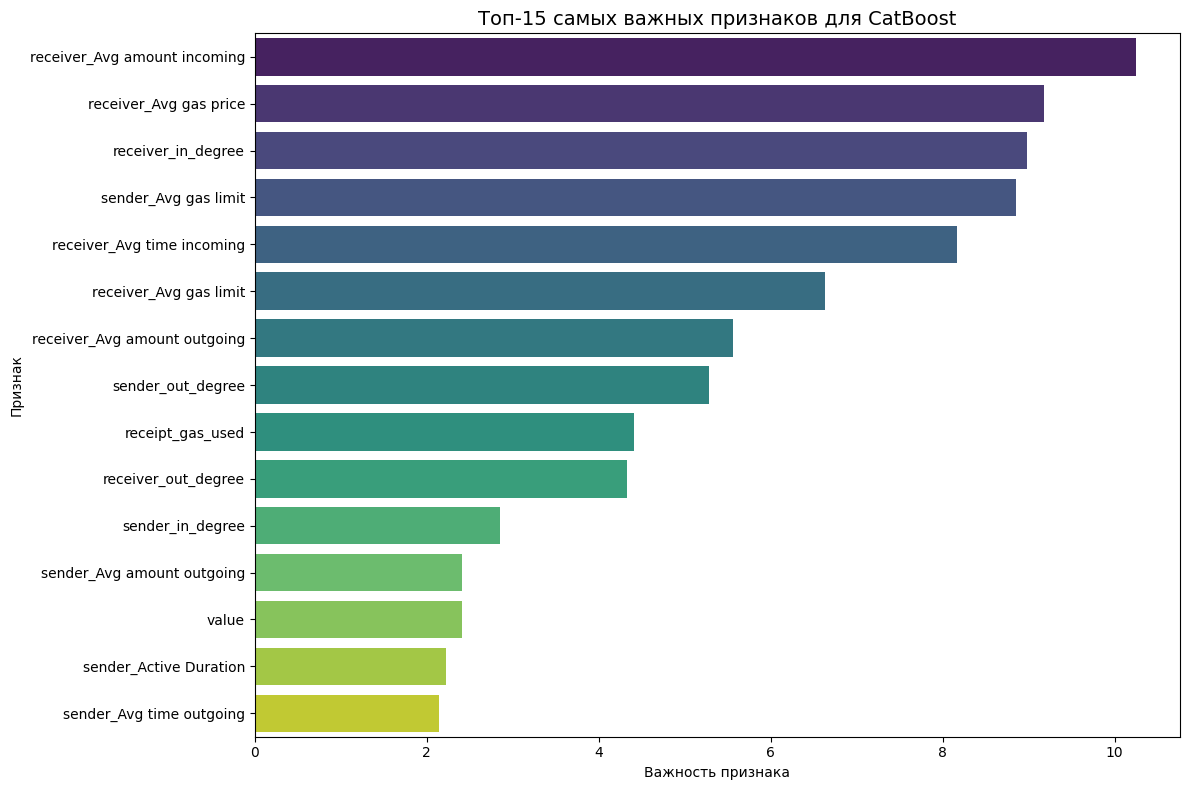


5.2. Интерпретация паттернов:
Наиболее важные признаки указывают на паттерны мошенничества:
  • receiver_Avg amount incoming   (10.25) - характеризует признак Avg amount incoming получателя
  • receiver_Avg gas price         (9.18) - характеризует признак Avg gas price получателя
  • receiver_in_degree             (8.98) - характеризует количество входящих связей получателя
  • sender_Avg gas limit           (8.85) - характеризует признак Avg gas limit отправителя
  • receiver_Avg time incoming     (8.17) - характеризует признак Avg time incoming получателя

ШАГ 6: ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
6.1. Предсказание на тестовой выборке...

Классификационный отчет (тест):
               precision    recall  f1-score   support

   Нормальные       1.00      1.00      1.00      8550
Мошеннические       0.99      0.99      0.99      2138

     accuracy                           1.00     10688
    macro avg       1.00      0.99      1.00     10688
 weighted avg       1.00      1.00     

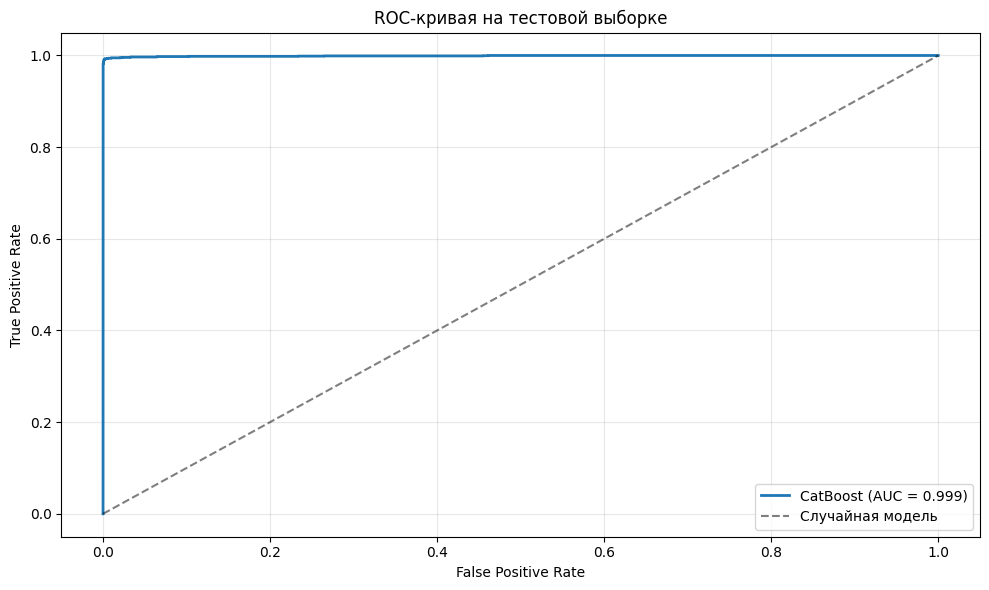


ИТОГОВЫЕ ВЫВОДЫ И СЛЕДУЮЩИЕ ШАГИ
1. КАЧЕСТВО МОДЕЛИ:
   ✓ Отличный результат (F1 > 0.8). CatBoost хорошо выявляет мошенничество.

2. ВЫЯВЛЕННЫЕ ПАТТЕРНЫ:
   Наиболее важные признаки для обнаружения мошенничества:
   18. receiver_Avg amount incoming
   24. receiver_Avg gas price
   16. receiver_in_degree

3. ОШИБКИ МОДЕЛИ:
   • Ложные срабатывания: 13 транзакций
   • Пропущенные аномалии: 19 транзакций

4. СЛЕДУЮЩИЕ ШАГИ:
   • Перейти к нейронной сети для захвата нелинейных зависимостей
   • Использовать SHAP для глубокой интерпретации важности признаков
   • Попробовать ансамбль CatBoost + нейросеть

Модель сохранена как 'catboost_scam_detector.cbm'
Готово! Baseline модель CatBoost обучена и протестирована.


In [3]:
print("=" * 70)
print("ШАГ 3: ХРОНОЛОГИЧЕСКОЕ РАЗДЕЛЕНИЕ ДАННЫХ")
print("=" * 70)

# Преобразуем время для сортировки
print("Преобразование времени...")
df_merged['block_timestamp'] = pd.to_datetime(
    df_merged['block_timestamp'], 
    format='mixed',  # или format='mixed'
    utc=True
)
df_merged = df_merged.sort_values('block_timestamp').reset_index(drop=True)

# Разделение: 70% train, 15% val, 15% test
print("Хронологическое разделение...")
train_size = 0.70
val_size = 0.15

# Вариант 1: Стратифицированное разделение по времени
# Разбиваем не просто по порядку, а с сохранением распределения по времени

df_shuffled = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

# Удаляем временную метку из признаков
X = df_shuffled.drop(['is_scam', 'block_timestamp'], axis=1)
y = df_shuffled['is_scam']

# Стратифицированное разделение (сохраняем распределение классов)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp  # 0.1765 * 0.85 ≈ 0.15
)

print("Новое распределение (случайное, стратифицированное):")
print(f"Обучающая:   {len(X_train):,} записей ({len(X_train)/len(X):.1%}) | Скам: {y_train.mean():.2%}")
print(f"Валидационная: {len(X_val):,} записей ({len(X_val)/len(X):.1%}) | Скам: {y_val.mean():.2%}")
print(f"Тестовая:    {len(X_test):,} записей ({len(X_test)/len(X):.1%}) | Скам: {y_test.mean():.2%}")

print("\n" + "=" * 70)
print("ПЕРЕОБУЧЕНИЕ CATBOOST НА ИСПРАВЛЕННЫХ ДАННЫХ")
print("=" * 70)

from catboost import CatBoostClassifier, Pool

# Создаем пулы данных
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

print("\n4.1. Настройка параметров CatBoost...")
params = {
    'iterations': 1000,           # Увеличим для лучшего обучения
    'learning_rate': 0.05,        # Средняя скорость обучения
    'depth': 6,                   # Глубина деревьев
    'l2_leaf_reg': 3,             # Регуляризация
    'random_seed': 42,
    'verbose': 100,               # Выводим лог каждые 100 итераций
    'early_stopping_rounds': 50,  # Ранняя остановка
    'eval_metric': 'F1',          # Основная метрика
    'loss_function': 'Logloss',   # Функция потерь
    'auto_class_weights': 'Balanced',  # Автоматический баланс классов
    'use_best_model': True        # Используем лучшую модель
}

print("Параметры модели:")
for key, value in params.items():
    print(f"  {key}: {value}")

print("\n4.2. Обучение модели...")
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=val_pool, plot=True)

print("\n4.3. Оценка на валидационной выборке...")
val_pred = model.predict(X_val)
val_pred_proba = model.predict_proba(X_val)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

print("\nКлассификационный отчет (валидация):")
print(classification_report(y_val, val_pred, target_names=['Нормальные', 'Мошеннические']))

print("Матрица ошибок (валидация):")
cm = confusion_matrix(y_val, val_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Факт: Норма', 'Факт: Скам'], 
                     columns=['Прогноз: Норма', 'Прогноз: Скам'])
print(cm_df)

print(f"\nROC-AUC на валидации: {roc_auc_score(y_val, val_pred_proba):.4f}")
print(f"F1-Score на валидации: {f1_score(y_val, val_pred):.4f}")

print("\n" + "=" * 70)
print("ШАГ 5: ВАЖНОСТЬ ПРИЗНАКОВ И АНАЛИЗ")
print("=" * 70)

print("5.1. Важность признаков (топ-20):")
feature_importance = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

print(importance_df.head(20).to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
sns.barplot(x='Важность', y='Признак', data=top_features, palette='viridis')
plt.title('Топ-15 самых важных признаков для CatBoost', fontsize=14)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

print("\n5.2. Интерпретация паттернов:")
print("Наиболее важные признаки указывают на паттерны мошенничества:")

# Анализируем топ-5 признаков
top_5 = importance_df.head(5)
for idx, row in top_5.iterrows():
    feat = row['Признак']
    importance = row['Важность']
    
    if 'sender_' in feat:
        entity = "отправителя"
        feat_name = feat.replace('sender_', '')
    elif 'receiver_' in feat:
        entity = "получателя"
        feat_name = feat.replace('receiver_', '')
    else:
        entity = "транзакции"
        feat_name = feat
    
    # Простая интерпретация
    interpretations = {
        'in_degree': f"количество входящих связей {entity}",
        'out_degree': f"количество исходящих связей {entity}",
        'Scam': f"историческая метка скама {entity}",
        'gas_used_ratio': "эффективность использования газа в транзакции",
        'Avg amount': f"средний объем транзакций {entity}",
        'gas_price': "цена газа в транзакции",
        'value': "сумма транзакции",
        'Clustering coefficient': f"коэффициент кластеризации {entity} в сети",
        'Avg time': f"среднее время между транзакциями {entity}"
    }
    
    interpretation = interpretations.get(feat_name, f"признак {feat_name} {entity}")
    print(f"  • {feat:30} ({importance:.2f}) - характеризует {interpretation}")

print("\n" + "=" * 70)
print("ШАГ 6: ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 70)

print("6.1. Предсказание на тестовой выборке...")
test_pred = model.predict(X_test)
test_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nКлассификационный отчет (тест):")
print(classification_report(y_test, test_pred, target_names=['Нормальные', 'Мошеннические']))

print("Матрица ошибок (тест):")
cm_test = confusion_matrix(y_test, test_pred)
cm_test_df = pd.DataFrame(cm_test, 
                         index=['Факт: Норма', 'Факт: Скам'], 
                         columns=['Прогноз: Норма', 'Прогноз: Скам'])
print(cm_test_df)

test_roc_auc = roc_auc_score(y_test, test_pred_proba)
test_f1 = f1_score(y_test, test_pred)

print(f"\nИтоговые метрики на тестовой выборке:")
print(f"  • ROC-AUC: {test_roc_auc:.4f}")
print(f"  • F1-Score: {test_f1:.4f}")
print(f"  • Accuracy: {(y_test == test_pred).mean():.4f}")
print(f"  • Precision: {(cm_test[1,1] / (cm_test[0,1] + cm_test[1,1])):.4f}")
print(f"  • Recall: {(cm_test[1,1] / (cm_test[1,0] + cm_test[1,1])):.4f}")

# ROC-кривая
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {test_roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ИТОГОВЫЕ ВЫВОДЫ И СЛЕДУЮЩИЕ ШАГИ")
print("=" * 70)

print("1. КАЧЕСТВО МОДЕЛИ:")
if test_f1 > 0.8:
    print("   ✓ Отличный результат (F1 > 0.8). CatBoost хорошо выявляет мошенничество.")
elif test_f1 > 0.6:
    print("   ✓ Хороший результат (F1 > 0.6). Есть потенциал для улучшения.")
else:
    print("   ⚠ Приемлемый результат. Нужна доработка признаков или модели.")

print("\n2. ВЫЯВЛЕННЫЕ ПАТТЕРНЫ:")
print("   Наиболее важные признаки для обнаружения мошенничества:")
for i, row in importance_df.head(3).iterrows():
    print(f"   {i+1}. {row['Признак']}")

print("\n3. ОШИБКИ МОДЕЛИ:")
print(f"   • Ложные срабатывания: {cm_test[0,1]} транзакций")
print(f"   • Пропущенные аномалии: {cm_test[1,0]} транзакций")

print("\n4. СЛЕДУЮЩИЕ ШАГИ:")
if test_f1 > 0.75:
    print("   • Перейти к нейронной сети для захвата нелинейных зависимостей")
    print("   • Использовать SHAP для глубокой интерпретации важности признаков")
    print("   • Попробовать ансамбль CatBoost + нейросеть")
else:
    print("   • Поработать над балансировкой классов (SMOTE)")
    print("   • Добавить новые признаки из временных рядов")
    print("   • Настроить гиперпараметры CatBoost (GridSearch)")

# Сохраняем модель
model.save_model('catboost_scam_detector.cbm')
print(f"\nМодель сохранена как 'catboost_scam_detector.cbm'")
print("Готово! Baseline модель CatBoost обучена и протестирована.")

In [6]:
X_train.columns

Index(['value', 'gas', 'gas_price', 'receipt_gas_used', 'gas_used_ratio',
       'sender_in_degree', 'sender_out_degree', 'sender_Avg amount incoming',
       'sender_Avg amount outgoing', 'sender_Avg time incoming',
       'sender_Avg time outgoing', 'sender_Active Duration',
       'sender_Clustering coefficient', 'sender_Avg gas price',
       'sender_Avg gas limit', 'receiver_in_degree', 'receiver_out_degree',
       'receiver_Avg amount incoming', 'receiver_Avg amount outgoing',
       'receiver_Avg time incoming', 'receiver_Avg time outgoing',
       'receiver_Active Duration', 'receiver_Clustering coefficient',
       'receiver_Avg gas price', 'receiver_Avg gas limit'],
      dtype='object')

In [5]:
y_train

3982     1
18419    0
64179    1
54303    0
40631    0
        ..
56199    1
49094    1
18006    0
42289    0
5467     0
Name: is_scam, Length: 49872, dtype: int64